In [1]:
"""
Assignment 1
Building a FNO model to learn how the material's stiffness distribution E(x) affects its deformation u(x)
input = E(x)
output = u(x) = (u^x, u^y)
"""

"\nAssignment 1\nBuilding a FNO model to learn how the material's stiffness distribution E(x) affects its deformation u(x)\ninput = E(x)\noutput = u(x) = (u^x, u^y)\n"

In [2]:
#Installing FEnICs
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2025-08-22 15:13:11--  https://fem-on-colab.github.io/releases/fenics-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.109.153, 185.199.111.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4180 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.08K  --.-KB/s    in 0s      

2025-08-22 15:13:11 (54.3 MB/s) - ‘/tmp/fenics-install.sh’ saved [4180/4180]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/6b0af652/releases/pybi

Initializing the parameters

In [3]:
# Parameters
L = 4.0
D = 1.0
Nx = 64
Ny = 32
n = 10

Text(0, 0.5, 'y grid')

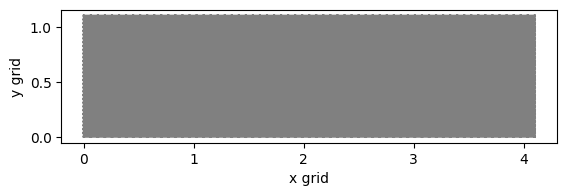

In [4]:
# Generating the dataset
import dolfin as df
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import time
import jax.numpy as jnp

#Build the mesh
mesh = df.RectangleMesh(df.Point(0.0, 0.0), df.Point(L + .1, D + .1), Nx, Ny, "crossed")
#mesh
plot(mesh)
plt.xlabel('x grid')
plt.ylabel('y grid')

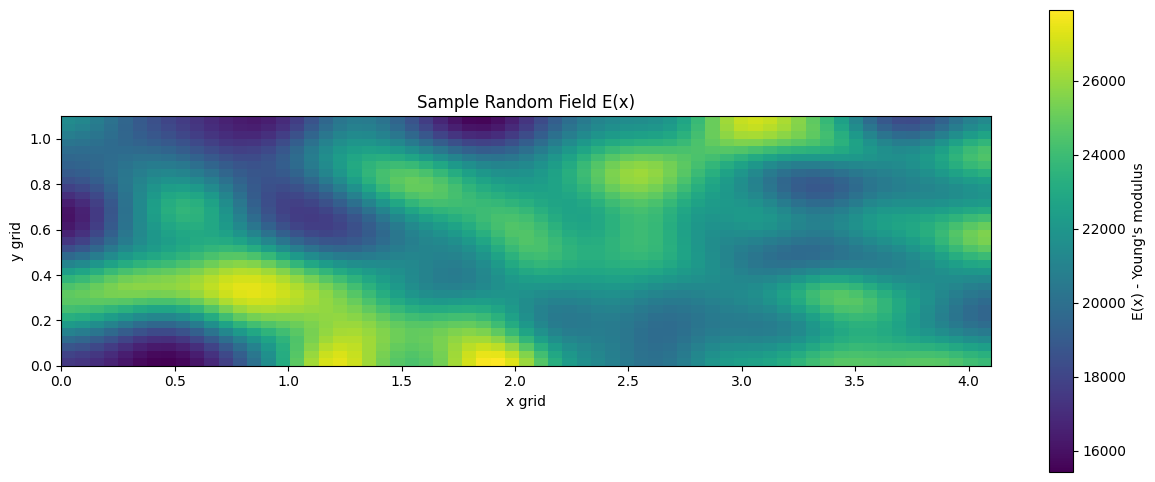

In [5]:

# Generate Random Field E(x) filtering white noise with an RBF kernel.
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# grid
#Nx, Ny = 64, 32
#L, D = 4.0, 1.0

# Parameters of the random field
mean = 10.0       # log of mean elasticity
sigma = 1      # standard deviation
ell = 3.0          # controls smoothness (correlation length)

# Generate random noise (white noise)
noise = np.random.normal(mean, scale=sigma, size=(Ny + 1, Nx + 1))

# Smooth it to create spatial correlation = filter with RBF kernel
noise_smooth = gaussian_filter(noise, sigma=ell)

# Exponentiate to ensure positive values
E_field = np.exp(noise_smooth)

# Step 4: Plot it, here the field is implicitly in the grid
plt.figure(figsize=(15, 6))
plt.imshow(E_field, extent=[0, L +.1, 0, D +.1], origin='lower', cmap='viridis')
plt.colorbar(label='E(x) - Young\'s modulus')
plt.title("Sample Random Field E(x)")
plt.xlabel('x grid')
plt.ylabel('y grid')
plt.show()

Generating a mesh grid from the Random Elasticity field

In [6]:
from scipy.interpolate import griddata, RegularGridInterpolator
"""
E_field: 2D numpy array (ny, nx)
x_coords: 1D array of x coordinates
y_coords: 1D array of y coordinates
mesh: FEniCS mesh using NumPy Interpolation
"""
Ny, Nx = E_field.shape
# Create function space and function
E_fspace = df.FunctionSpace(mesh, "Lagrange", 2)
E_f = df.Function(E_fspace)

x_grid = np.linspace(0, L, Nx)  # Nx points from 0 to L
y_grid = np.linspace(0, D, Ny)  # Ny points from 0 to D

# Get mesh vertex coordinates
mesh_coords = E_fspace.tabulate_dof_coordinates()

# Create interpolator
interp = RegularGridInterpolator((y_grid, x_grid), E_field,
                                method='linear', bounds_error=False, fill_value=None)

# Interpolate to mesh points
mesh_points = mesh_coords[:, [1, 0]]
values = interp(mesh_points)

# Assign to FEniCS function
E_f.vector()[:] = values

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_6ab56968c6ffa883272fd990bd40fad8bf858cca

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00374007 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.314725 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:----------------------------

Interpolation converts E_field from NumPy grid to FEniCS's mesh-based represenattion

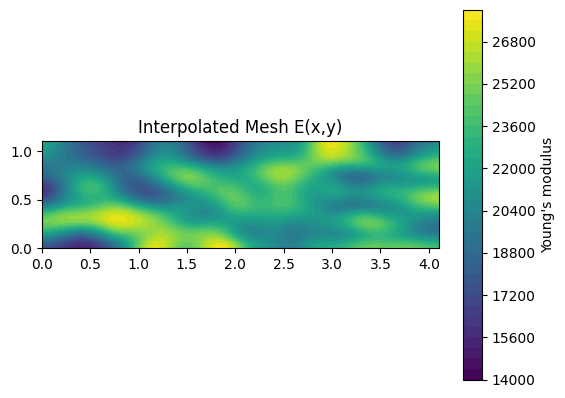

In [7]:
# Plot E(x,y) on the FEniCS mesh
p = df.plot(E_f, title="Interpolated Mesh E(x,y)")  # store the mappable
plt.colorbar(p, label="Young's modulus")       # pass it to colorbar
plt.show()

In [8]:
#PDE solver
param_c = 10
tolerance = 1e-6#1e-15
left = df.CompiledSubDomain("near(x[0], side) && on_boundary", side=0.0, tol=tolerance)
S = E_f.function_space()  # Get the scalar function space of E_f
V = df.VectorFunctionSpace(mesh, "Lagrange", 2)
c = df.Expression(("0.0", "0.0"), degree=2)
# Apply Dirichlet boundary condition on the left side
bcs = df.DirichletBC(V, c, left)

# Define functions
du = df.TrialFunction(V)  # Incremental displacement
v = df.TestFunction(V)  # Test function
u = df.Function(V)  # Displacement from previous iteration


D = mesh.topology().dim()
neumann_domain = df.MeshFunction("size_t", mesh, D - 1)
neumann_domain.set_all(0)
df.CompiledSubDomain("near(x[0], side) && on_boundary", side=L, tol=tolerance).mark(neumann_domain, 1)
ds = df.Measure("ds", subdomain_data=neumann_domain)


# Kinematics
d_dim = u.geometric_dimension()
I = df.Identity(d_dim)  # Identity tensor
# requires vector
deformation_gradient = I + df.grad(u)  # Deformation gradient
Cauchy_tensor = deformation_gradient.T * deformation_gradient  # Right Cauchy-Green tensor


c  = df.Constant(param_c)
c1 = df.project(E_f / 4, S)  # Project E_f/4 into the same function space
c2 = df.project(E_f / 8, S)  # Project E_f/8 into the same function space
d = df.Constant(100.0) # d = 2 * (c1 + 2 * c2)



# Invariants
J_invariant = df.det(deformation_gradient)
I1 = df.tr(Cauchy_tensor)
I2 = 0.5 * (I1 ** 2 - df.tr(Cauchy_tensor * Cauchy_tensor))
# Stored strain energy density, energy type = mooneyrivlin
psi = c * (J_invariant - 1)**2 - d * df.ln(J_invariant) + c1 * (I1 - 2) + c2 * (I2 - 1)


class TractionExpression0(df.UserExpression):  # Constant traction on both x, y components
      def eval(self, value, _x):
          value[0] = 1e2
          value[1] = 1e3
t = TractionExpression0(degree=2, element=V.ufl_element())

start_time = time.time()
#dot requires non-scalar arguments
#solve
u.vector()[:] = 0
Pi = psi * df.dx - df.dot(t, u) * ds(1)
F = df.derivative(Pi, u, v)
J = df.derivative(F, u, du)
problem = df.NonlinearVariationalProblem(F, u, bcs, J)
solver = df.NonlinearVariationalSolver(problem)
prm = solver.parameters
prm["newton_solver"]["absolute_tolerance"] = 1E-6
prm["newton_solver"]["relative_tolerance"] = 1E-7
prm["newton_solver"]["maximum_iterations"] = 50
prm["newton_solver"]["relaxation_parameter"] = 0.8
prm["newton_solver"]["linear_solver"] = "mumps"
prm["newton_solver"]["error_on_nonconvergence"] = False
try:
    solver.solve()
    print("Successfully converged!")
except RuntimeError as e:
    print(f"Solver failed: {e}")
    print("Try load stepping or reduce material parameters")
print("Running time = %.3f" % float(time.time() - start_time))

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_f4c31f6e8b0e7ddceb14ce599aa08d063c1bdf82

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00196671 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0153217 seconds.

INFO:FFC:Compiler stage 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_9e8b33ce463ffaefb412f9d85746d2cd0101b27b

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG2(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0374386 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3c618518e8c24ef176053339223d0e2a16e51755

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00169134 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00808859 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representat

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_dd9baaea625355081b5519d8763464dc23cc7161

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00230026 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0108263 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_1575c8990a1bfe2d6ccd0768ddad9511ab150295

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00267935 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0127821 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_84d495a78101e005b3c3473583b2e920e2771158

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00277734 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0102644 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_b9fabc5bf48bac253837a1d4838d3b1c5e733f30

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0128784 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_e1bd8378c1e55d7bfba6717391248dbf7ace2c45

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0469103 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_1fc521580da0bed54dbda435536c9e3f6f1bbb63

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 2
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              6
  Coefficients:                        '[f_12, f_17, f_24, f_39, f_48, f_49]'
  Unique elements:                     'Vector<2 x CG2(?,?)>, R0(?,?), CG2(?,?), Vec
                                       tor<2 x CG1(?,?)>'
  Unique sub elements:                 'Vector<2 x CG2(?,?)>, R0(?,?), CG

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00220108 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0103481 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00210309 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0100691 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_17d5bd7e022a45e71c9f390bd00f3f09885a1fd0

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00222063 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00979781 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representat

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00262141 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00998926 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INF

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_4fb1133ea5c30aa02c6e66bf32751f6fa7ef01f1

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    5
  Coefficients:              '[f_12, f_17, f_24, f_39, f_48]'
  Unique elements:           'Vector<2 x CG2(?,?)>, R0(?,?), CG2(?,?), Vector<2 x CG
                             1(?,?)>'
  Unique sub elements:       'Vector<2 x CG2(?,?)>, R0(?,?), CG2(?,?), Vector<2 x CG
                             1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  qu

Successfully converged!
Running time = 30.527


In [17]:
# Get the grid dimensions (should match your E_field)
Ny, Nx = E_field.shape

# Recreate the same grid you used for interpolation
x_grid = np.linspace(0, L, Nx)
y_grid = np.linspace(0, 1.0, Ny)  # End at 1.0 as requested
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

# Method 1: Vectorized evaluation using numpy.vectorize
def evaluate_displacement(x, y):
    """Evaluate FEniCS displacement function at point (x, y)"""
    try:
        # u(x, y) returns the displacement vector at point (x, y)
        point_displacement = u(x, y)
        return float(point_displacement[0]), float(point_displacement[1])
    except:
        return np.nan, np.nan

# Vectorize the function for efficient evaluation
u_vectorized = np.vectorize(evaluate_displacement)

# Calculate displacements for all grid points at once
disp_x_exact, disp_y_exact = u_vectorized(X_grid, Y_grid)


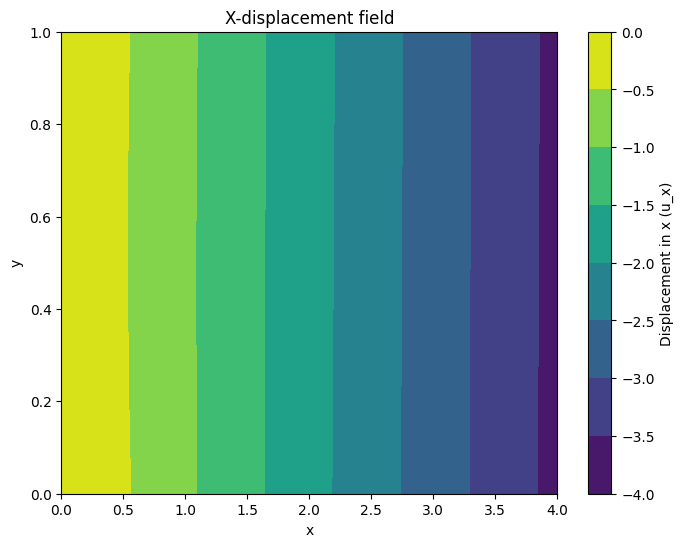

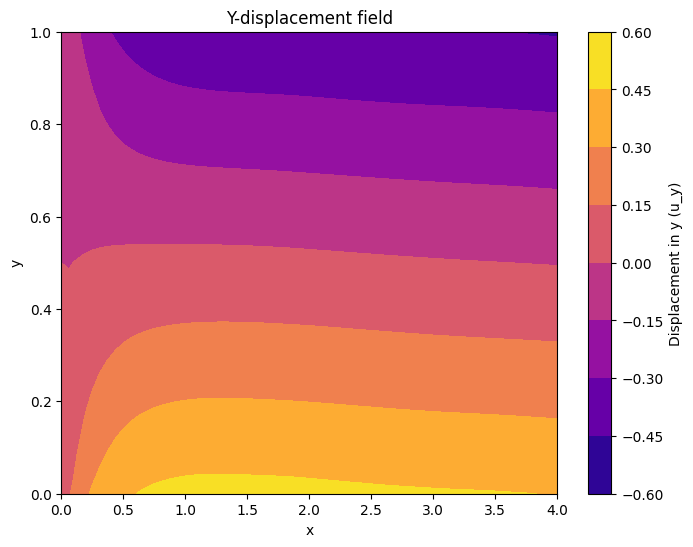

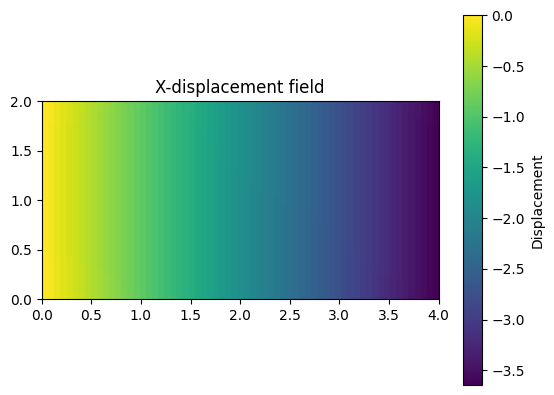

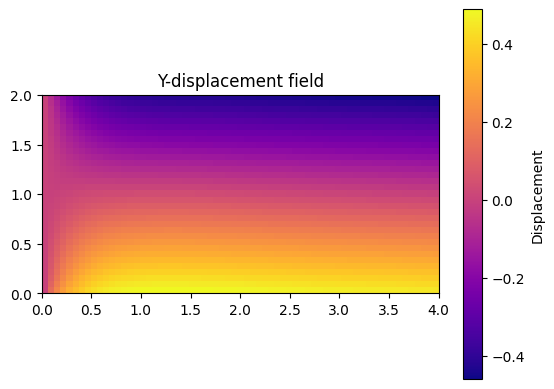

In [18]:
import matplotlib.pyplot as plt

# Plot x-displacement
plt.figure(figsize=(8,6))
plt.contourf(X_grid, Y_grid, disp_x_exact, cmap='viridis')
plt.colorbar(label='Displacement in x (u_x)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('X-displacement field')
plt.show()

# Plot y-displacement
plt.figure(figsize=(8,6))
plt.contourf(X_grid, Y_grid, disp_y_exact, cmap='plasma')
plt.colorbar(label='Displacement in y (u_y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Y-displacement field')
plt.show()

import numpy as np

# Suppose Ux_grid, Uy_grid are your displacement grids, smooth it out
# Mask NaNs
Ux_masked = np.ma.masked_invalid(disp_x_exact)
#plt.colorbar(label='Displacement in x (u_x)')
plt.imshow(Ux_masked, origin='lower', extent=(0, L, 0, D))
plt.colorbar(label="Displacement")
plt.title('X-displacement field')
plt.show()
Uy_masked = np.ma.masked_invalid(disp_y_exact)
plt.imshow(Uy_masked, origin='lower', extent=(0, L, 0, D), cmap= 'plasma')
plt.colorbar(label="Displacement")
plt.title('Y-displacement field')
plt.show()

In [20]:
# Get traction values (assuming you want the values you applied) into np arrays
tx = np.full((Ny, Nx), 1e2)
ty = np.full((Ny, Nx), 1e3)


bc_info = {
    'type': 'Dirichlet',
    'applied_on': 'left boundary (x=0)',
    'value': (0.0, 0.0)
}


dataset = {
    'E_field': E_field,  # Input electric field (Ny, Nx)
    'displacement_x': Ux_masked,  # Output x-displacement (Ny, Nx)
    'displacement_y': Uy_masked,  # Output y-displacement (Ny, Nx)
    'applied_traction_x': 1e2,  # Applied forces in x-direction (Ny, Nx)
    'applied_traction_y': 1e3,  # Applied forces in y-direction (Ny, Nx)
    'boundary_conditions': bc_info,  # Fixed/free boundary conditions
    'x_coords': x_grid,  # 1D array of x coordinates
    'y_coords': y_grid,  # 1D array of y coordinates
    'parameters': {
        'param_c': param_c,
        'bulk_modulus': float(d),
        'L': L,
        'D': D
    }
}

print(f"Dataset number {counter + 1} has been generated")
print(f"Grid size: {Nx} x {Ny} = {Nx*Ny} points")
#print(f"Max displacement: x={np.max(np.abs(u_x_interp)):.6f}, y={np.max(np.abs(u_y_interp)):.6f}")
print("Running time = %.3f" % (time.time() - start_time))
import numpy as np

filename = "/content/drive/MyDrive/Assignment 1/dataset_0008.npz"
np.savez(filename, **dataset)

Dataset number 1 has been generated
Grid size: 65 x 33 = 2145 points
Running time = 3254.940


In [15]:

import numpy as np

filename = "/content/drive/MyDrive/Assignment 1/dataset_0006.npz"
np.savez(filename, **dataset)
